## Lenet (посмотреть какая точность) максимум 88.5%

Ниже запустил Lenet на FashonMNIST. Эта сеть по аналогии с тем, что была на лекции, только датасет другой. Как окажется, не достаточно точный на тестовой выборке результат, будет внизу ещё одна сеть.

In [ ]:
import torchvision as tv
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
BATCH_SIZE=256

In [ ]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

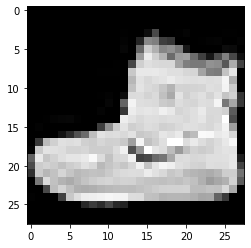

In [ ]:
plt.imshow(train_dataset[0][0].numpy().reshape(28,28), cmap='gray')

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 12, 10, 10])
Layer ReLU(). X shape: torch.Size([1, 12, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 12, 5, 5])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 300])
Layer Linear(in_features=300, out_features=50, bias=True). X shape: torch.Size([1, 50])
Layer ReLU(). X shape: torch.Size([1, 50])
Layer Linear(in_features=50, out_features=10, bias=True). X shape: torch.Size([1, 10])


In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
y = model(X)
print(y.shape)

torch.Size([1, 10])


In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs)

epoch 1, loss 0.3407, train acc 0.874, test acc 0.866, time 16.5 sec
epoch 2, loss 0.3276, train acc 0.878, test acc 0.870, time 16.4 sec
epoch 3, loss 0.3169, train acc 0.883, test acc 0.875, time 16.5 sec
epoch 4, loss 0.3079, train acc 0.885, test acc 0.874, time 16.3 sec
epoch 5, loss 0.2999, train acc 0.888, test acc 0.877, time 16.4 sec
epoch 6, loss 0.2925, train acc 0.891, test acc 0.880, time 16.3 sec
epoch 7, loss 0.2865, train acc 0.894, test acc 0.881, time 16.4 sec
epoch 8, loss 0.2798, train acc 0.896, test acc 0.883, time 16.3 sec
epoch 9, loss 0.2750, train acc 0.897, test acc 0.883, time 16.4 sec
epoch 10, loss 0.2697, train acc 0.899, test acc 0.885, time 16.4 sec


## CNN_FashionMNIST (надо улучшать модель) максимум

Придумаем собственную сеть, чтобы улучшить метрику.

In [ ]:
import torch
from torch import nn

In [ ]:
import torchvision as tv
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
BATCH_SIZE=256

In [ ]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

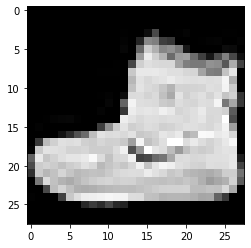

In [ ]:
plt.imshow(train_dataset[0][0].numpy().reshape(28,28), cmap='gray')

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64*6*6, 600),
    nn.ReLU(),
    nn.Dropout2d(0.25),
    nn.Linear(600, 120),
    nn.ReLU(),
    nn.Linear(120, 10)
)

In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)). X shape: torch.Size([1, 32, 28, 28])
Layer BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 32, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 32, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 32, 14, 14])
Layer Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)). X shape: torch.Size([1, 64, 12, 12])
Layer BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 64, 12, 12])
Layer ReLU(). X shape: torch.Size([1, 64, 12, 12])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 64, 6, 6])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 2304])
Layer Linear(in_features=2304, out_features=600, bias=True). X shape: torch.Size([1, 600])
Layer ReLU(). X shape:

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs)

epoch 1, loss 0.6703, train acc 0.755, test acc 0.858, time 82.9 sec
epoch 2, loss 0.3588, train acc 0.868, test acc 0.869, time 83.7 sec
epoch 3, loss 0.2935, train acc 0.891, test acc 0.895, time 83.7 sec
epoch 4, loss 0.2594, train acc 0.903, test acc 0.902, time 84.1 sec
epoch 5, loss 0.2387, train acc 0.911, test acc 0.901, time 83.6 sec
epoch 6, loss 0.2155, train acc 0.920, test acc 0.911, time 84.0 sec
epoch 7, loss 0.1987, train acc 0.926, test acc 0.906, time 83.8 sec
epoch 8, loss 0.1821, train acc 0.932, test acc 0.908, time 83.6 sec
epoch 9, loss 0.1690, train acc 0.938, test acc 0.913, time 83.8 sec
epoch 10, loss 0.1564, train acc 0.942, test acc 0.914, time 84.0 sec


## Обучение на GPU (для CNN_FashionMNIST) на GPU и быстрей и точней...

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
dev

device(type='cuda')

In [ ]:
model = model.to(dev)

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.2170, train acc 0.918, test acc 0.908, time 7.2 sec
epoch 2, loss 0.1997, train acc 0.925, test acc 0.906, time 7.1 sec
epoch 3, loss 0.1838, train acc 0.932, test acc 0.912, time 7.1 sec
epoch 4, loss 0.1721, train acc 0.935, test acc 0.911, time 7.1 sec
epoch 5, loss 0.1594, train acc 0.940, test acc 0.911, time 7.2 sec
epoch 6, loss 0.1462, train acc 0.946, test acc 0.915, time 7.2 sec
epoch 7, loss 0.1377, train acc 0.949, test acc 0.910, time 7.2 sec
epoch 8, loss 0.1260, train acc 0.953, test acc 0.910, time 7.1 sec
epoch 9, loss 0.1166, train acc 0.956, test acc 0.913, time 7.2 sec
epoch 10, loss 0.1089, train acc 0.960, test acc 0.918, time 7.1 sec
